In [51]:
from __future__ import print_function

import argparse

import numpy as np
import torch
import torch.utils.data

import make_lsm_signals
from model import RecurrentNetTimeVariable

import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
use_cuda = False
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = RecurrentNetTimeVariable(n_in=200, n_hid=500, n_out=1,
                                     use_cuda=use_cuda).to(device)
model.load_state_dict(torch.load('./trained_models/04171515_lsmsignals_netsize_500_stimdur_7_nstim_3_respdur_5_epoch_501.pth', map_location='cpu'))



cpu


In [81]:
def lsm_signals(n_episodes=100, n_in=100, stim_dur=15,
                sig1_stim_dur=20, resp_dur=10, each_episodes=10, kappa=5.0, spon_rate=0.08, n_stim=3):
    phi = np.linspace(0, np.pi, n_in)
    n_loc = 1
    nneuron = n_in * n_loc
    total_dur = n_stim * (stim_dur + resp_dur)
    G = (1.0 / stim_dur) * np.random.choice([1.0], 1)
    G = np.repeat(G, n_in, axis=0).T
    G = np.tile(G, (stim_dur, 1))

    # signal2
    Stims = []
    Stims_ = []
    Ls = []
    Rs = []
    for episode in range(n_episodes):
        episode_stim = []
        for i in range(n_stim):
            S = np.pi * np.random.rand(1)
            S_ = S.copy()
            S = np.repeat(S, n_in, axis=0).T
            S = np.tile(S, (stim_dur, 1))
            Stims.append(S)
            episode_stim.append(S_)

            # Noisy responses
            L = G * np.exp(kappa * (np.cos(
                2.0 * (S - np.tile(phi, (stim_dur, n_loc)))) - 1.0))  # stim

            Ls.append(L)
            R = np.random.poisson(L)
            Rs.append(R)
        Stims_.append(episode_stim)
        Lr = (spon_rate / resp_dur) * np.ones((resp_dur * n_stim, nneuron))  # resp
        Rr = np.random.poisson(Lr)

        Rs.append(Rr)

    signal2 = np.concatenate(tuple(Rs), axis=0)

    G1 = (3.0 / sig1_stim_dur) * np.random.choice([1.0], 1)
    G1 = np.repeat(G1, n_in, axis=0).T
    G1 = np.tile(G1, (sig1_stim_dur, 1))
    # signal1 & target
    a = np.random.poisson(0.8, n_episodes)
    Rs1 = []
    accum_signal = np.pi * np.random.rand(1)
    target_list = []

    for episode in range(n_episodes):
        target_list.append(np.zeros(stim_dur * n_stim))
        if a[episode] == 2 or episode % each_episodes == 0:
            print(episode)
            accum_signal = np.pi * np.random.rand(1)
            S = np.repeat(accum_signal, n_in, axis=0).T
            S = np.tile(S, (sig1_stim_dur, 1))

            L = G1 * np.exp(kappa * (np.cos(
                2.0 * (S - np.tile(phi, (sig1_stim_dur, n_loc)))) - 1.0))  # stim
            R = np.random.poisson(L)
            Rs1.append(R)
        else:
            Lr = (spon_rate / resp_dur) * np.ones((sig1_stim_dur, nneuron))  # resp
            R = np.random.poisson(Lr)
            Rs1.append(R)
        L_spont = (spon_rate / resp_dur) * np.ones((total_dur - sig1_stim_dur, nneuron))  # resp
        R = np.random.poisson(L_spont)
        Rs1.append(R)

        for i in range(n_stim):
            target = np.repeat(Stims_[episode][i]+accum_signal, resp_dur, axis=0)
            # target = np.repeat(Stims_[episode][i], resp_dur, axis=0)
            target_list.append(target)

    signal1 = np.concatenate(tuple(Rs1), axis=0)

    target = np.concatenate(tuple(target_list), axis=0)
    target = np.expand_dims(target, 1)

    signal = np.concatenate((signal1, signal2), axis=1)
    return signal, target

In [82]:
signals = []
targets = []
for i in range(1):
    signal, target = lsm_signals(n_episodes=20,
                                                  stim_dur=7,
                                                  sig1_stim_dur=7,
                                                  resp_dur=5,
                                                  each_episodes=7,
                                                  spon_rate=0.01)
    signals.append(signal)
    targets.append(target)

signals = np.array(signals)
targets = np.array(targets)

signals = torch.from_numpy(signals)
targets = torch.from_numpy(targets)

hidden = torch.zeros(1, 500, requires_grad=False)
hidden = hidden.to(device)

signals = signals.float()
targets = targets.float()

signals, targets = signals.to(device), targets.to(device)

hidden_list, output, hidden = model(signals, hidden)


0
3
5
6
7
8
14


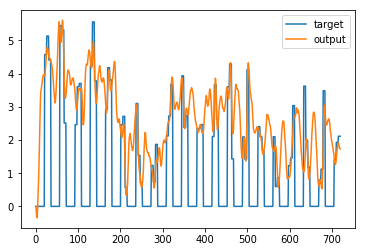

In [83]:
plt.plot(targets[0].data.numpy().T[0], label='target')
plt.plot(output[0].data.numpy().T[0], label='output')
plt.legend()

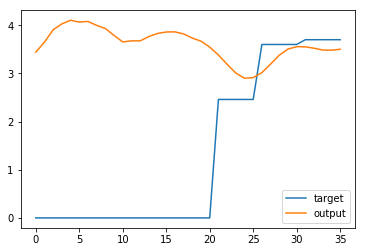

In [84]:
plt.plot(targets[0].data.numpy().T[0][72:108], label='target')
plt.plot(output[0].data.numpy().T[0][72:108], label='output')
plt.legend()
# plt.savefig('result/long_short/training_result.png')

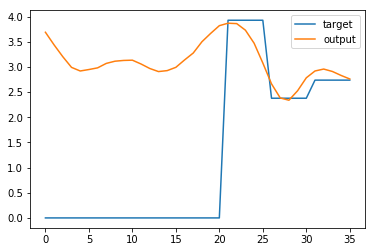

In [85]:
plt.plot(targets[0].data.numpy().T[0][324:360], label='target')
plt.plot(output[0].data.numpy().T[0][324:360], label='output')
plt.legend()

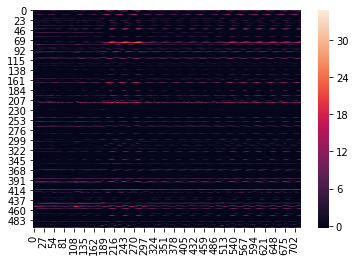

In [86]:
import seaborn as sns
sns.heatmap(hidden_list.data.numpy()[0].T)

Text(33,0.5,'neuron index')

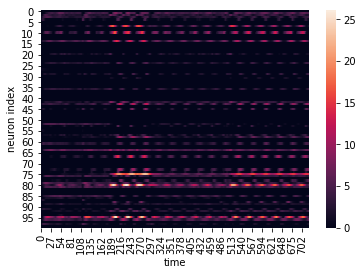

In [87]:
sns.heatmap(hidden_list.data.numpy()[0].T[:100])
plt.xlabel('time')
plt.ylabel('neuron index')
# plt.savefig('internal_dynamics2.png')

Text(33,0.5,'neuron index')

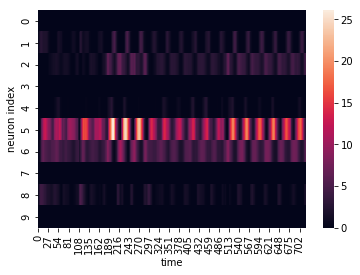

In [88]:
sns.heatmap(hidden_list.data.numpy()[0].T[90:100])
plt.xlabel('time')
plt.ylabel('neuron index')
# plt.savefig('result/long_short/neurons_activation1.png')

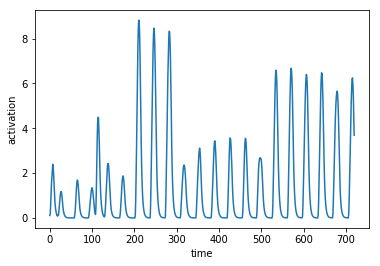

In [89]:
plt.plot(hidden_list.data.numpy()[0].T[45])
plt.xlabel('time')
plt.ylabel('activation')
plt.savefig('result/long_short/neurons_activation2.png')

Text(0,0.5,'activation')

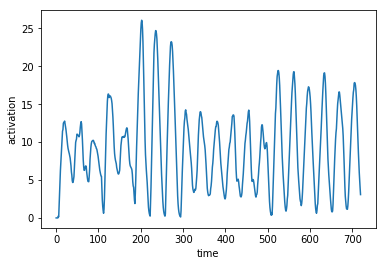

In [90]:
plt.plot(hidden_list.data.numpy()[0].T[95])
plt.xlabel('time')
plt.ylabel('activation')
# plt.savefig('result/long_short/neurons_activation2.png')

Text(33,0.5,'neuron index')

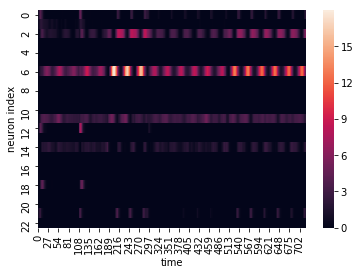

In [92]:
sns.heatmap(hidden_list.data.numpy()[0].T[161:184])
plt.xlabel('time')
plt.ylabel('neuron index')

Text(0,0.5,'activation')

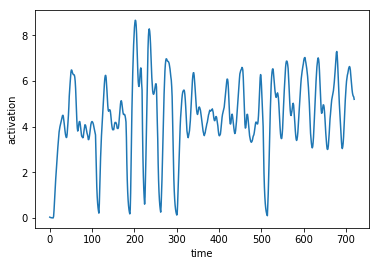

In [93]:
plt.plot(hidden_list.data.numpy()[0].T[1])
plt.xlabel('time')
plt.ylabel('activation')
# plt.savefig('result/long_short/neurons_activation3.png')

Text(33,0.5,'neuron index')

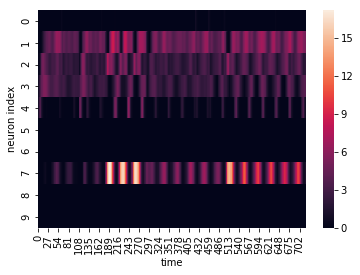

In [94]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:10])
plt.xlabel('time')
plt.ylabel('neuron index')

Text(0.5,1,'dynamics of neurons during one episode')

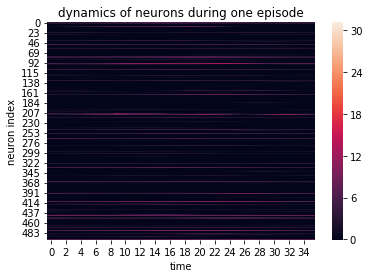

In [95]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:500, 36:72])
plt.xlabel('time')
plt.ylabel('neuron index')
plt.title('dynamics of neurons during one episode')

# plt.savefig('dynamics2.png')

Text(33,0.5,'neuron index')

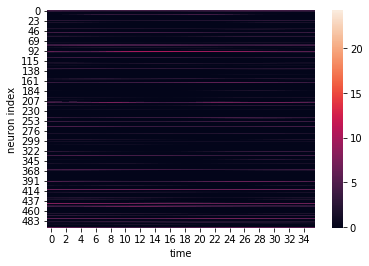

In [96]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:500, 72:108])
plt.xlabel('time')
plt.ylabel('neuron index')

Text(33,0.5,'neuron index')

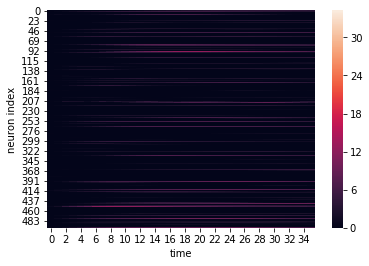

In [97]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:500, :36])
plt.xlabel('time')
plt.ylabel('neuron index')
# plt.savefig('result/long_short/neurons_activation4.png')

Text(33,0.5,'neuron index')

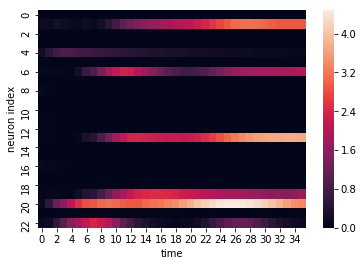

In [98]:
sns.heatmap(hidden_list.data.numpy()[0].T[23:46, :36])
plt.xlabel('time')
plt.ylabel('neuron index')

Text(0,0.5,'activation')

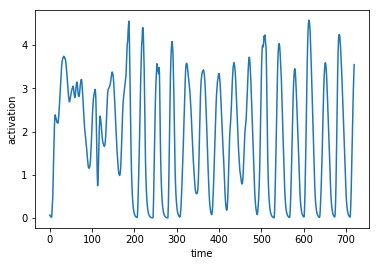

In [99]:
plt.plot(hidden_list.data.numpy()[0].T[36])
plt.xlabel('time')
plt.ylabel('activation')
# plt.savefig('activation2.png')

Text(33,0.5,'neuron index')

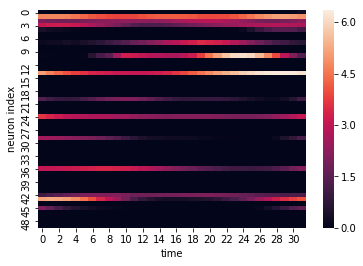

In [100]:
sns.heatmap(hidden_list.data.numpy()[0].T[0:50, 140:172])
plt.xlabel('time')
plt.ylabel('neuron index')

Text(33,0.5,'neuron index')

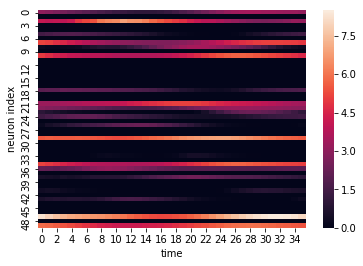

In [101]:
sns.heatmap(hidden_list.data.numpy()[0].T[-50:, 72:108])
plt.xlabel('time')
plt.ylabel('neuron index')

In [79]:
model.alpha.weight

Parameter containing:
tensor([[0.3025],
        [0.3114],
        [0.3005],
        [0.3039],
        [0.3158],
        [0.2726],
        [0.2983],
        [0.2873],
        [0.2789],
        [0.2850],
        [0.3835],
        [0.3024],
        [0.2984],
        [0.2727],
        [0.2853],
        [0.2879],
        [0.2394],
        [0.2861],
        [0.3046],
        [0.2387],
        [0.3051],
        [0.2975],
        [0.3082],
        [0.3105],
        [0.3142],
        [0.2883],
        [0.2960],
        [0.0719],
        [0.2617],
        [0.3075],
        [0.3004],
        [0.3051],
        [0.3031],
        [0.2877],
        [0.3013],
        [0.2994],
        [0.2985],
        [0.2963],
        [0.2883],
        [0.2841],
        [0.2956],
        [0.3013],
        [0.3007],
        [0.3139],
        [0.2951],
        [0.3070],
        [0.2700],
        [0.3297],
        [0.2881],
        [0.2836],
        [0.2918],
        [0.1719],
        [0.2968],
        [0.2681],
      

In [80]:
model.alpha.weight.sort()

(tensor([[0.3025],
         [0.3114],
         [0.3005],
         [0.3039],
         [0.3158],
         [0.2726],
         [0.2983],
         [0.2873],
         [0.2789],
         [0.2850],
         [0.3835],
         [0.3024],
         [0.2984],
         [0.2727],
         [0.2853],
         [0.2879],
         [0.2394],
         [0.2861],
         [0.3046],
         [0.2387],
         [0.3051],
         [0.2975],
         [0.3082],
         [0.3105],
         [0.3142],
         [0.2883],
         [0.2960],
         [0.0719],
         [0.2617],
         [0.3075],
         [0.3004],
         [0.3051],
         [0.3031],
         [0.2877],
         [0.3013],
         [0.2994],
         [0.2985],
         [0.2963],
         [0.2883],
         [0.2841],
         [0.2956],
         [0.3013],
         [0.3007],
         [0.3139],
         [0.2951],
         [0.3070],
         [0.2700],
         [0.3297],
         [0.2881],
         [0.2836],
         [0.2918],
         [0.1719],
         [0.